# Mini-Project 1 : Image Classification and Regression and Denoising

## Yonatan DELORO, Master MVA (contact : yonatan.deloro@eleves.enpc.fr)

You will find a description of my solution and my comments upon the obtained results at the end of each section/subsection 1) ; 2); 3)a) ; 3)b) ; 4); 5).

## 0. Imports and Code from utils.py 

(I copy-pasted here the initial code from utils.py, so that the present .ipynb file is "self-contained")

In [46]:
#imports

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, Flatten, Reshape
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from pylab import rcParams
rcParams['figure.figsize'] = 7,7

IMAGE_SIZE = 72

In [2]:
## On some implementations of matplotlib, you may need to change this value

def generate_a_drawing(figsize, U, V, noise=0.0, pair=False):
    #if pair=True, returns the pair of the noised image and the image without the noise
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    if pair:
        imdata0 = imdata.copy()
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    if pair:
        return imdata, imdata0
    else:
        return imdata

def generate_a_rectangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise, pair=pair)


def generate_a_disk(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise, pair=pair)

def generate_a_triangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise, pair=pair)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y, IMAGE_SIZE):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Part 1 : Simple Classification

In [3]:
[X, Y] = generate_dataset_classification(650, noise=20)
[X_train, Y_train] = [X[:300],Y[:300]]
[X_val, Y_val] = [X[300:350],Y[300:350]]
[X_test, Y_test] = [X[350:],Y[350:]]

Creating data:
Done


In [4]:
def build_linear_classifier():
    model = Sequential()
    model.add(Dense(3, input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    model.add(Activation('softmax'))
    return model

model = build_linear_classifier()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [5]:
optimizers = {
   "sgd" : SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
   "adam" : Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
}

early_stopping_monitor = EarlyStopping(patience = 5)

In [6]:
categorical_Y_train = to_categorical(Y_train)
categorical_Y_val = to_categorical(Y_val)

losses = {}
trained_models = {}

for (name_opt,opt) in optimizers.items():
    print("\nTraining the model with "+name_opt)

    model = build_linear_classifier()
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics = ["accuracy"])
    history = model.fit(X_train, categorical_Y_train, validation_data=(X_val,categorical_Y_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

    losses[name_opt]= {}
    losses[name_opt]["train"] = history.history['loss']
    losses[name_opt]["val"] = history.history['val_loss']
    
    trained_models[name_opt] = model


Training the model with sgd
Train on 300 samples, validate on 50 samples
Epoch 1/100
300/300 [==============================] - 0s 435us/step - loss: 1.1787 - acc: 0.4100 - val_loss: 1.0320 - val_acc: 0.5400
Epoch 2/100
300/300 [==============================] - 0s 72us/step - loss: 0.7136 - acc: 0.7033 - val_loss: 0.5376 - val_acc: 0.8400
Epoch 3/100
300/300 [==============================] - 0s 85us/step - loss: 0.5213 - acc: 0.7933 - val_loss: 0.4433 - val_acc: 0.8400
Epoch 4/100
300/300 [==============================] - 0s 73us/step - loss: 0.4017 - acc: 0.8833 - val_loss: 0.3629 - val_acc: 0.9000
Epoch 5/100
300/300 [==============================] - 0s 85us/step - loss: 0.3115 - acc: 0.9333 - val_loss: 0.3100 - val_acc: 0.9400
Epoch 6/100
300/300 [==============================] - 0s 81us/step - loss: 0.2865 - acc: 0.9333 - val_loss: 0.4209 - val_acc: 0.8000
Epoch 7/100
300/300 [==============================] - 0s 81us/step - loss: 0.2610 - acc: 0.9533 - val_loss: 0.3053 - val

300/300 [==============================] - 0s 72us/step - loss: 0.0774 - acc: 0.9933 - val_loss: 0.0883 - val_acc: 1.0000
Epoch 22/100
300/300 [==============================] - 0s 75us/step - loss: 0.0772 - acc: 0.9967 - val_loss: 0.0913 - val_acc: 1.0000
Epoch 23/100
300/300 [==============================] - 0s 72us/step - loss: 0.0708 - acc: 0.9967 - val_loss: 0.0898 - val_acc: 1.0000
Epoch 24/100
300/300 [==============================] - 0s 67us/step - loss: 0.0656 - acc: 1.0000 - val_loss: 0.0852 - val_acc: 0.9800
Epoch 25/100
300/300 [==============================] - 0s 68us/step - loss: 0.0684 - acc: 0.9967 - val_loss: 0.0746 - val_acc: 1.0000
Epoch 26/100
300/300 [==============================] - 0s 71us/step - loss: 0.0566 - acc: 1.0000 - val_loss: 0.0698 - val_acc: 1.0000
Epoch 27/100
300/300 [==============================] - 0s 73us/step - loss: 0.0581 - acc: 1.0000 - val_loss: 0.0716 - val_acc: 1.0000
Epoch 28/100
300/300 [==============================] - 0s 74us/step

Epoch 82/100
300/300 [==============================] - 0s 75us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 83/100
300/300 [==============================] - 0s 71us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 1.0000
Epoch 84/100
300/300 [==============================] - 0s 70us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 69us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 70us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 71us/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 70us/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 1.0000
Epoch 89/100
300/300 [==============================] -

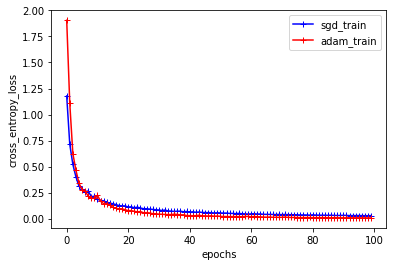

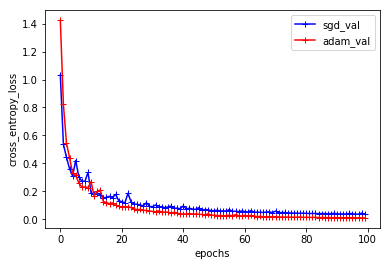

In [7]:
epochs_sgd = np.arange(len(losses['sgd']['train']))
epochs_adam = np.arange(len(losses['adam']['train']))

plt.plot(epochs_sgd,losses["sgd"]['train'],marker="+",color="b",label="sgd_train")
plt.plot(epochs_adam,losses["adam"]['train'],marker="+",color="r",label="adam_train")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

plt.plot(epochs_sgd,losses["sgd"]['val'],marker="+",color="b",label="sgd_val")
plt.plot(epochs_adam,losses["adam"]['val'],marker="+",color="r",label="adam_val")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

In [8]:
categorical_Y_test = to_categorical(Y_test)
res = trained_models["sgd"].evaluate(X_test, categorical_Y_test)
print("SGD optimizer.\ncross-entropy loss, accuracy score : \n",res,"\n")

res = trained_models["adam"].evaluate(X_test, categorical_Y_test)
print("Adam optimizer.\ncross-entropy loss, accuracy score : \n",res)

300/300 [==============================] - 0s 45us/step
SGD optimizer.
cross-entropy loss, accuracy score : 
 [0.036620580106973645, 0.9966666666666667] 

300/300 [==============================] - 0s 37us/step
Adam optimizer.
cross-entropy loss, accuracy score : 
 [0.011868260279297828, 1.0]


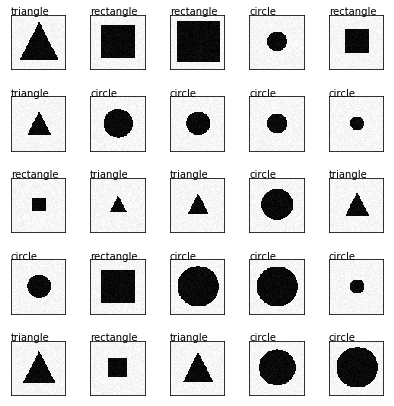

In [9]:
#plotting some data and their predictions

name_labels = ["rectangle","circle", "triangle"]

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for (idx,k) in enumerate(np.random.choice(X_test.shape[0],25)):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_test[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    predicted_Y = model.predict(X_test[k][None,:])
    label = name_labels[np.argmax(predicted_Y)]
    ax[i,j].text(-0.5,-0.5,label,fontsize=10)

plt.show()

### Part 1 - Comments

- For this first classification problem, I used as advised a simple linear classifier composed of one fully-connected layer taking as inputs the flattened images (72.72 = 5184) and with 3 outputs (weights of dimension 5184.3 + 3 = 15555 as mentionned in the summary of the model), followed by a softmax activation to "get" the probabilities to belong to each of the three classes rectangle/circle/triangle. I used the cross-entropy as for the loss function, well adapted to the output probability vector and the hot-encoded true label.


- I trained the model with two different optimizers : Stochastic Gradient Descent with momentum and Nesterov acceleration, and the Adam optimizer with default parameters. SGD enabled to reach an almost perfect accuracy score on the test set (99,7%) and Adam perfectly classified the shapes. In addition we can observe that the Adam optimizer led to a smaller cross-entropy loss than SGD (0.01 against 0.04).


- Adam optimizer indeed uses and updates at each iteration a learning rate specific to each parameter of the model (which decreases with the running average of the second order momentum of the gradient with respect to the parameter). It is therefore better for sparse gradients (we will see when visualizing the solution that not all the parameters contribute to the final label) and the learning rate parameter to provide has less impact than in SGD (it is modified throughout the iterations from the initial given value).

# Part 2 - Visualization of the Solution

Column 0 of the weights


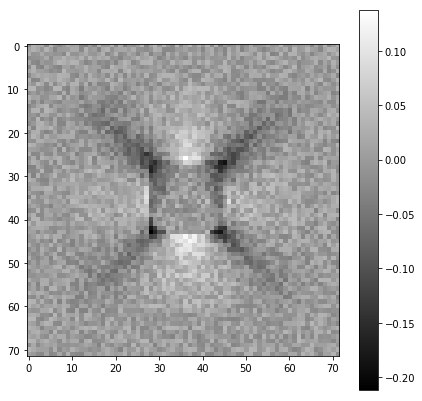

Column 1 of the weights


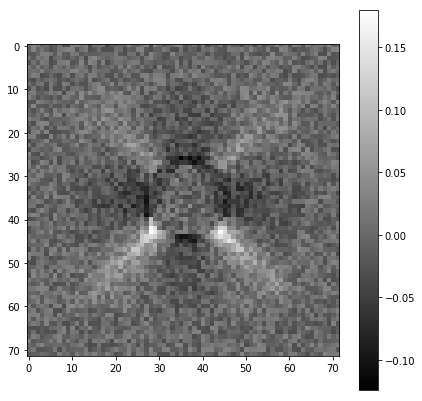

Column 2 of the weights


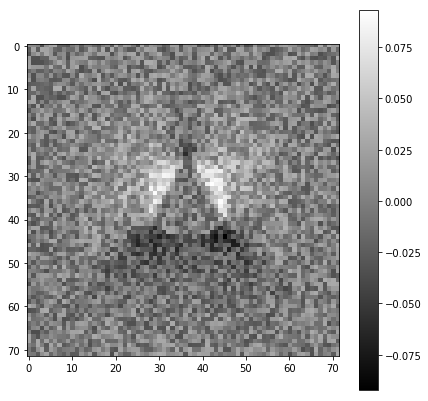

In [52]:
model = trained_models["adam"]
W = model.get_weights()[0] #only focus on W (not intercept)

for col in range(W.shape[1]):
    print("Column "+str(col)+" of the weights")
    im = plt.imshow(W[:,col].reshape((IMAGE_SIZE,IMAGE_SIZE)), cmap='gray')
    plt.colorbar(im, cmap='gray')
    plt.show()

### Part 2 - Comments

- Each column of the weight matrix (without the bias) contributes to the probability to belong to one of the three classes (column 0 : rectangle, column 1 : circle,  column 2 : triangle). Besides, each column of dimension 5184 = 72.72 can be visualized as an image, and the signed intensity of each pixel can be interpreted as how much a white pixel in the input image at this location will increase or decrease (depending on the sign) the probability to belong to one of the three classes (the more black, the more negative contribution if the pixel of the input image is white ; the more white, the more positive contribution if the pixel of the input image is white).

Visualization seems consistent with what we could have expected : 

- The first column of the weight will output a low value for the probability to be a rectangle if does not find four black pixels located on the diagonals, which would indeed correspond to the four corners of a rectangle since it is located at the center (indeed, negative contribution if a pixel on a diagonal of the input image is white as the weight is negative, and zero contribution if black).


- The second column of the weight will output a high value for the probability to be a circle if it does not find any black pixel on the diagonals, ie. a corner of a rectangle/triangle (indeed, positive contribution if a pixel on a diagonal of the input image is white as the weight is positive, and zero if black). 


- The third column of the weight will output a low value for the probability to be a triangle if it does not find black pixel on the diagonals at the bottom of the image (indeed, negative contribution if a pixel on a "bottom"diagonal of the input image is white as the weight is negative, and zero contribution if black).

# Part 3 - A More Difficult Classification Problem

## a)  trying the same linear classifier

In [11]:
N_train = 2000 ; N_val = 100 
N_total = N_train + N_val

[X, Y] = generate_dataset_classification(N_total, noise=20, free_location=True)
[X_train, Y_train] = [X[:N_train],Y[:N_train]]
[X_val, Y_val] = [X[N_train:],Y[N_train:]]

[X_test, Y_test] =  generate_test_set_classification()

categorical_Y_train = to_categorical(Y_train)
categorical_Y_val = to_categorical(Y_val)
categorical_Y_test = Y_test #Y_test already categorical

Creating data:
Done
Creating data:
Done


In [12]:
model = build_linear_classifier()
model.compile(loss='categorical_crossentropy',optimizer=optimizers["adam"], metrics = ["accuracy"])
history = model.fit(X_train, categorical_Y_train, validation_data=(X_val,categorical_Y_val), epochs=30, callbacks=[early_stopping_monitor], batch_size=32)

Train on 2000 samples, validate on 100 samples
Epoch 1/30
2000/2000 [==============================] - 0s 120us/step - loss: 6.1612 - acc: 0.4365 - val_loss: 7.2806 - val_acc: 0.3600
Epoch 2/30
2000/2000 [==============================] - 0s 58us/step - loss: 5.6693 - acc: 0.5185 - val_loss: 6.3079 - val_acc: 0.5500
Epoch 3/30
2000/2000 [==============================] - 0s 61us/step - loss: 5.4706 - acc: 0.5795 - val_loss: 6.2939 - val_acc: 0.5500
Epoch 4/30
2000/2000 [==============================] - 0s 66us/step - loss: 5.4855 - acc: 0.5600 - val_loss: 6.3069 - val_acc: 0.5100
Epoch 5/30
2000/2000 [==============================] - 0s 61us/step - loss: 5.4993 - acc: 0.5635 - val_loss: 6.2922 - val_acc: 0.5400
Epoch 6/30
2000/2000 [==============================] - 0s 62us/step - loss: 5.4553 - acc: 0.5835 - val_loss: 6.3773 - val_acc: 0.5300
Epoch 7/30
2000/2000 [==============================] - 0s 68us/step - loss: 5.4184 - acc: 0.5930 - val_loss: 6.4864 - val_acc: 0.4300
Epoch 8

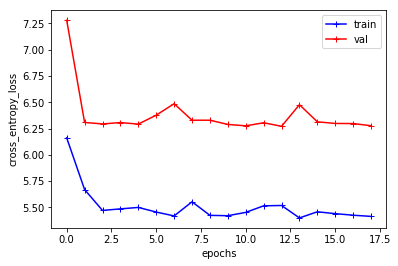

In [13]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

In [14]:
res = model.evaluate(X_test, categorical_Y_test)
print("Adam optimizer.\ncross-entropy loss, accurracy score : \n",res,"\n")

300/300 [==============================] - 0s 35us/step
Adam optimizer.
cross-entropy loss, accurracy score : 
 [5.6322938394546505, 0.6233333325386048] 



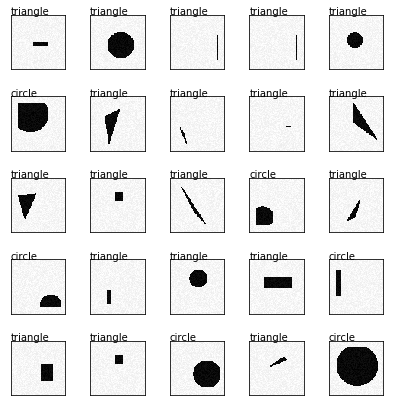

In [15]:
#plotting some data and their predictions

name_labels = ["rectangle","circle", "triangle"]

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

selection = np.random.choice(X_test.shape[0],25)
for (idx,k) in enumerate(selection):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_test[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    predicted_Y = model.predict(X_test[k][None,:])
    label = name_labels[np.argmax(predicted_Y)]
    ax[i,j].text(-0.5,-0.5,label,fontsize=10)

plt.show()

### Part 3)a) - Comments

- As we see, for this more difficult task (free location of shapes and different dimensions), the same classifier will only lead to an accuracy score on the test set around 62%. Circles and triangles are sometimes well-identified but the network never outputs the rectangle label. It means that the three classes are not linearly separable.


- Note : I trained the classifier on 2000 samples to enable comparison with the following convolutional network. I used the Adam optimizer, and early stopping to avoid doing iterations for nothing (stops after 5 epochs with no improvement on the validation loss, 100 number of epochs at max).

## b)  trying a simple convolutional network

In [16]:
def build_convolutional_network():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model

In [17]:
def reshape_as_images(X):
    nb_samples = X.shape[0]
    X2 = np.zeros((nb_samples,IMAGE_SIZE,IMAGE_SIZE,1))
    for k in range(nb_samples):
        X2[k,:] = np.reshape(X[k,:],(IMAGE_SIZE,IMAGE_SIZE,1))
    return X2

In [18]:
print(X_train.shape)
X_train = reshape_as_images(X_train)
print(X_train.shape)

X_val = reshape_as_images(X_val)
X_test = reshape_as_images(X_test)

(2000, 5184)
(2000, 72, 72, 1)


In [19]:
model = build_convolutional_network()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=optimizers["adam"], metrics = ["accuracy"])
history = model.fit(X_train, categorical_Y_train, validation_data=(X_val,categorical_Y_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 55491     
_________________________________________________________________
activation_5 (Activation)    (None, 3)                 0         
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 100 samples
Epoch 1/100
2000/2000 [==============================] - 4s 2ms/step - loss: 1.1054 - acc: 

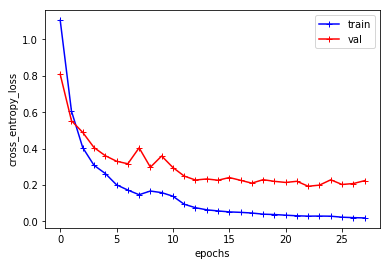

In [20]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

In [21]:
res = model.evaluate(X_test, categorical_Y_test)
print("Adam optimizer.\ncross-entropy loss, accurracy score : \n",res,"\n")

300/300 [==============================] - 0s 853us/step
Adam optimizer.
cross-entropy loss, accurracy score : 
 [0.26662447253863014, 0.923333334128062] 



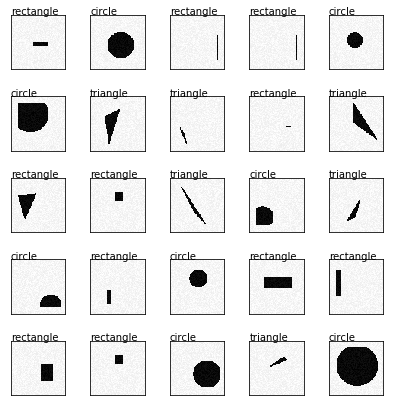

In [22]:
#plotting some data and their predictions

name_labels = ["rectangle","circle", "triangle"]

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for (idx,k) in enumerate(selection):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_test[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    predicted_Y = model.predict(X_test[k][None,:])
    label = name_labels[np.argmax(predicted_Y)]
    ax[i,j].text(-0.5,-0.5,label,fontsize=10)

plt.show()

### Part 3)b) - Comments

- I then implemented the convolutional network described in the assignment : 1 convolutional layer with 16 filters of size (5,5) followed by a relu activation, 1 max-pooling layer (pool size (2,2)), and 1 fully-connected layer (input dimension : dimension of flattened output of maxpool layer, and 3 output units) followed by a softmax activation. Again I used the cross-entropy loss. 


- Such a convolutional network led to an accuracy score on the test set around 92% (against 62% for the linear classifier). The value of the cross-entropy loss on the test set is 0.26 (against 5.63 for the linear classifier).


- Note : I trained the classifier on the same set of 2000 samples as the linear classifier. I again used the Adam optimizer, and early stopping to avoid doing iterations for nothing and to avoid overfitting (stops after 5 epochs with no improvement on the validation loss, 100 number of epochs at max).

# Part 4 - A Regression Problem

In [54]:
N_train = 2000 ; N_val = 100
N_total = N_train + N_val

[X, Y] = generate_dataset_regression(N_total, noise=20)
[X_train, Y_train] = [X[:N_train],Y[:N_train]]
[X_val, Y_val] = [X[N_train:],Y[N_train:]]

[X_test, Y_test] = generate_test_set_regression()

Creating data:
Done
Creating data:
Done


In [55]:
X_train = reshape_as_images(X_train)
X_val = reshape_as_images(X_val)
X_test = reshape_as_images(X_test)

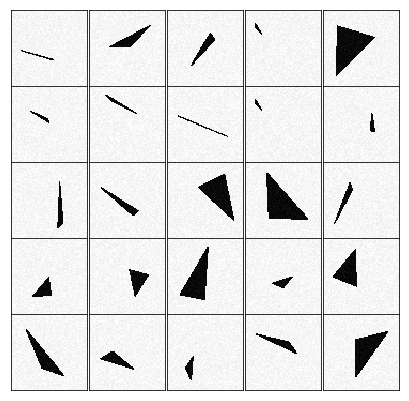

In [56]:
#visualizing some images of the dataset

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0., wspace=0.)

for (idx,k) in enumerate(np.random.choice(X_test.shape[0],25)):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_train[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.show()

In [57]:
def normalize(Y):
    
    #sort vertices by distances to origin
    
    Z = np.zeros((Y.shape[0],6))
    
    r0A = Y[:,0]*Y[:,0] + Y[:,1]*Y[:,1] 
    r0B = Y[:,2]*Y[:,2] + Y[:,3]*Y[:,3]
    r0C = Y[:,4]*Y[:,4] + Y[:,5]*Y[:,5]
    
    M = np.argsort(np.array([r0A,r0B,r0C]).T,axis=1)
            
    for k in range(M.shape[0]):
        Z[k,0] = Y[k,2*M[k,0]] #abciss of vertex with smallest distance to origin
        Z[k,1] = Y[k,2*M[k,0]+1]  
        Z[k,2] = Y[k,2*M[k,1]]
        Z[k,3] = Y[k,2*M[k,1]+1]
        Z[k,4] = Y[k,2*M[k,2]]
        Z[k,5] = Y[k,2*M[k,2]+1]
    
    return Z

In [58]:
Z_train = normalize(Y_train)
Z_val = normalize(Y_val)
Z_test = normalize(Y_test)

In [59]:
def build_regressor():
    
    model = Sequential()
    
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.3))
    
    model.add(Flatten())    
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6))
    
    return model

In [60]:
model = build_regressor()
model.summary()

model.compile(loss='mean_squared_error',optimizer=optimizers['adam'])
history = model.fit(X_train, Z_train, validation_data=(X_val,Z_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 16)        6416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 16)          0         
__________

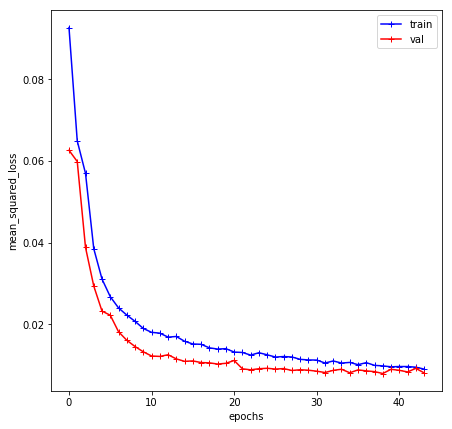

In [61]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("mean_squared_loss") ; plt.legend()
plt.show()

In [63]:
res = model.evaluate(X_test, Z_test)
print("Adam optimizer.\nmean-squared loss :",res,"\n")

300/300 [==============================] - 0s 2ms/step
Adam optimizer.
mean-squared loss : 0.011156736960013708 



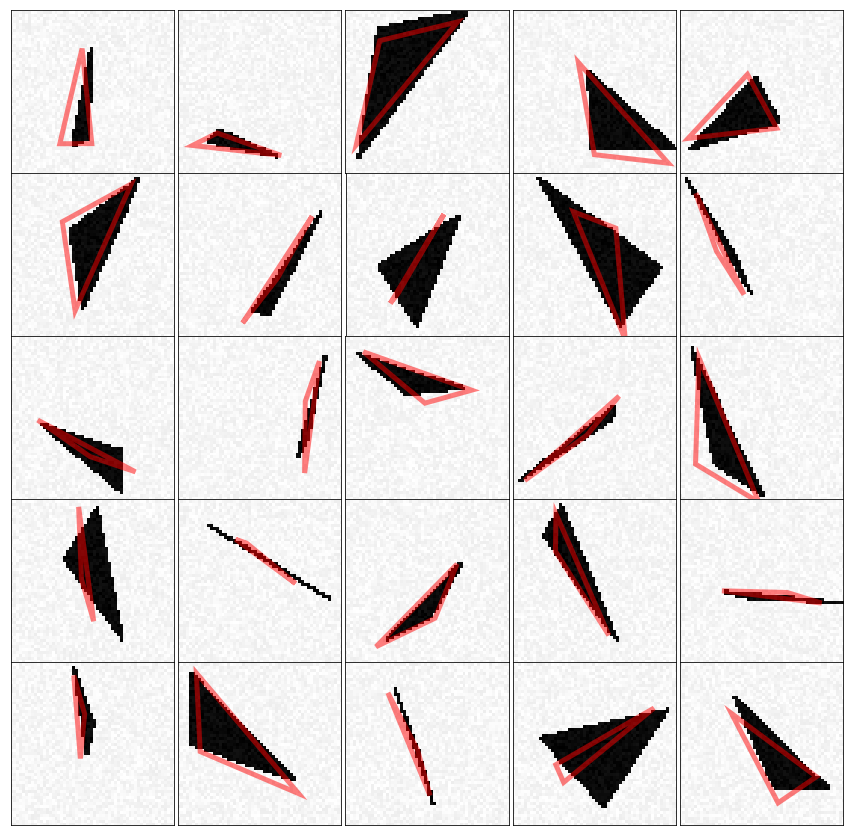

In [62]:
def visualize_prediction(x, y, IMAGE_SIZE, ax):
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace=0., wspace=0.)

selection = np.random.choice(X_test.shape[0],25)
for (idx,k) in enumerate(selection):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    x = X_test[k,:]
    y = model.predict(x[None,:,:,:])
    visualize_prediction(x, y, IMAGE_SIZE, ax[i, j])
    
plt.show()    

### Part 4) - Comments

- For this regression task, I chose a network composed of 3 convolutional layers with 16 5×5 filters followed each by relu activation (features extraction part) and 3 fully connected layers (respective output dimensions : 256,64,6) the first two followed by relu activation. I also used dropout to avoid overfitting (probability of dropout : 0.3). I used the mean squared loss function, well-adapted for regression. 


- In addition, I "normalized" the triangles in such a way that the output vector the network should predict is defined in a unique way, ie. the locations of the vertices sorted in a given way. The ordering which worked best for me is to sort the vertices by their distances to the origin. (I also tried to order the vertices by the angles with the abciss axis of the vectors coming from the barycenter to each vertex, but it led to larger validation loss (probably led to more mistakes for triangles almost equilateral))


- Ordering vertices by distances to the origin as for the normalization, such a regressor could lead to a mean squared loss of 0.011 on the test set. However, plots shows that we still make sometimes quite big mistakes (though, it does not seem to happen particularly when two vertices are at similar distances from the origin).


- Note : I trained the classifier on the same set of 2000 samples. I again used the Adam optimizer, and early stopping to avoid doing iterations for nothing and to avoid overfitting (stops after 5 epochs with no improvement on the validation loss, 100 number of epochs at max).  

# Part 5 -  Image Denoising

In [33]:
def generate_dataset_denoising(nb_samples, max_noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = max_noise*np.random.rand()
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location, pair=True)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location, pair=True)
        else:
            X[i], Y[i] = generate_a_triangle(noise, free_location, pair=True)[0]
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255
    print("Done")
    return [X, Y]


def generate_test_set_denoising(max_noise=0.0):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, max_noise=max_noise, free_location=True)
    return [X_test, Y_test]

In [34]:
max_noise = 500

N_train = 300 ; N_val = 100
N_total = N_train + N_val

[X, Y] = generate_dataset_denoising(N_total, max_noise=max_noise, free_location=True)
[X_train, Y_train] = [X[:N_train],Y[:N_train]]
[X_val, Y_val] = [X[N_train:],Y[N_train:]]

[X_test, Y_test] = generate_test_set_denoising(max_noise=max_noise)

Creating data:
Done
Creating data:
Done


Image without noise (left) and with noise (right)


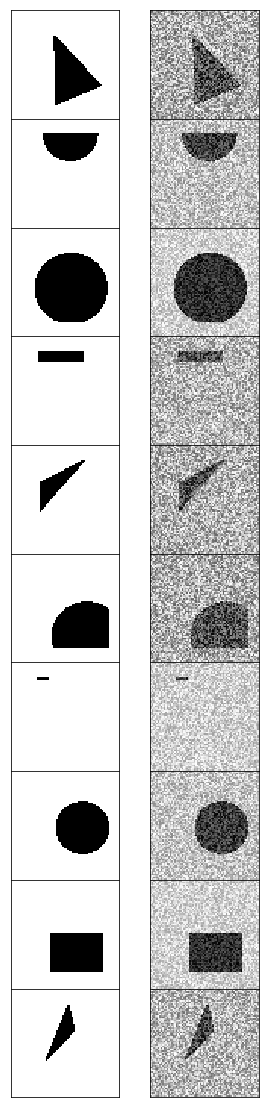

In [35]:
#visualizing some images of the train dataset

print("Image without noise (left) and with noise (right)")

fig, ax = plt.subplots(10, 2, figsize=(5, 20))
fig.subplots_adjust(hspace=0., wspace=0.)

for (i,k) in enumerate(np.random.choice(X_train.shape[0],10)):
    
    ax[i, 0].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].imshow(Y_train[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    
    ax[i, 1].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].imshow(X_train[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.show()

In [36]:
X_train = reshape_as_images(X_train)
Y_train = reshape_as_images(Y_train)

X_val = reshape_as_images(X_val)
Y_val = reshape_as_images(Y_val)

X_test = reshape_as_images(X_test)
Y_test = reshape_as_images(Y_test)

In [37]:
def build_hourglass_network():
    
    model = Sequential()
    
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same',input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2DTranspose(16, (5, 5), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(16, (5, 5), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [38]:
model = build_hourglass_network()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam')
history = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 16)        6416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 18, 18, 16)        6416      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 36, 36, 16)        6416      
__________

300/300 [==============================] - 3s 9ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 67/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0223 - val_loss: 0.0227
Epoch 68/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 69/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0210 - val_loss: 0.0209
Epoch 70/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0207 - val_loss: 0.0216
Epoch 71/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0209 - val_loss: 0.0210
Epoch 72/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0209 - val_loss: 0.0210
Epoch 73/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0207 - val_loss: 0.0209
Epoch 74/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0207 - val_loss: 0.0218


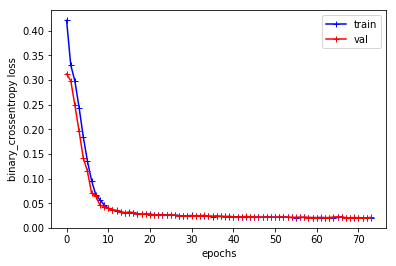

300/300 [==============================] - 1s 3ms/step
Adam optimizer.
binary_crossentropy loss :  0.04023025130232175 



In [39]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("binary_crossentropy loss") ; plt.legend()
plt.show()

res = model.evaluate(X_test, Y_test)
print("Adam optimizer.\nbinary_crossentropy loss : ",res,"\n")

Image without noise (left), noised image (middle) and denoised image (right)


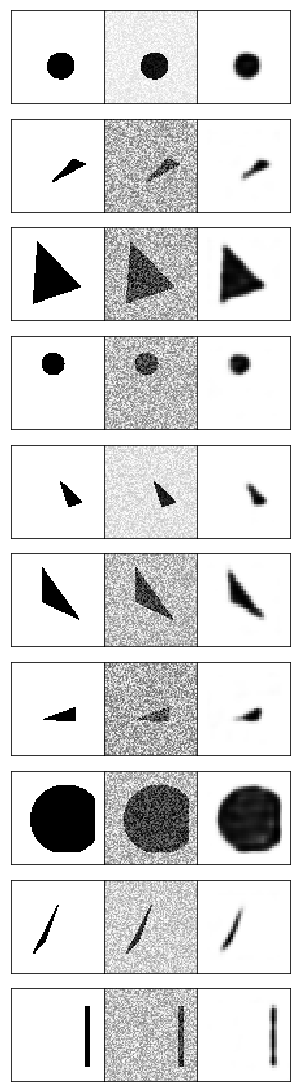

In [40]:
#Visualizing some denoised images of the test dataset

selection = np.random.choice(X_test.shape[0],10)
input_images = X_test[selection] 
output_images = Y_test[selection] 
denoised_images =  model.predict(input_images)

print("Image without noise (left), noised image (middle) and denoised image (right)")

fig, ax = plt.subplots(10, 3, figsize=(5, 20))
fig.subplots_adjust(hspace=0., wspace=0.)

for i in range(len(input_images)):
    
    ax[i, 0].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].imshow(output_images[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    
    ax[i, 1].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].imshow(input_images[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
        
    ax[i, 2].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 2].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 2].imshow(denoised_images[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.show()

### Part 5) - Comments


- The data I worked on is noisy images of shapes with free locations/dimensions, noise being chosen uniformly at random between 0 and 500.


- The denoising network I implemented is composed of 2 convolutional layers with 16 5×5 filters followed each by relu activation and max-pooling (pool size of (2,2)), 2 transposed convolutional layers followed each by relu activation and up-sampling (factor (2,2) again), and finally a linear layer with 16 inputs and 1 ouput applied to each of the 72.72 pixels "embeddings" of size 16, followed by sigmoid activation, in order to get as final output an image of size (72,72) with values betwen 0 and 1. I used the binary cross-entropy loss, well adapted here (image without noise has binary intensities, and denoised image has intensities between 0 and 1).


- Binary cross-entropy loss is 0.04 on the test set at the end of the optimization. Plots shows that the network generally succeeds in removing the noise, but it also smooths the frontiers of the shapes. This results in mistakes when the shape is particularly thin (cf. thin triangle).


- Note : I trained the classifier on 300 samples. I again used the Adam optimizer, and early stopping to avoid doing iterations for nothing and to avoid overfitting (stops after 5 epochs with no improvement on the validation loss, 100 number of epochs at max). 